In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_133730/1256517549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import roc_curve, auc

(array([0., 1.]), array([35052, 34948]))


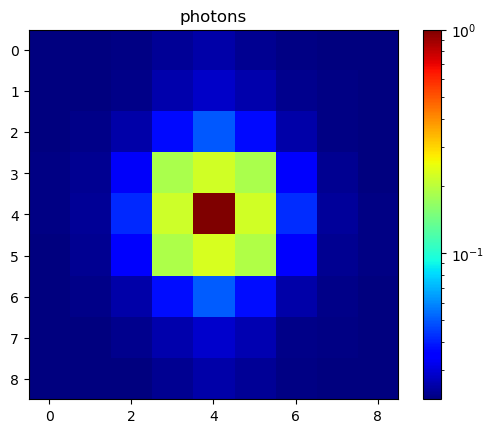

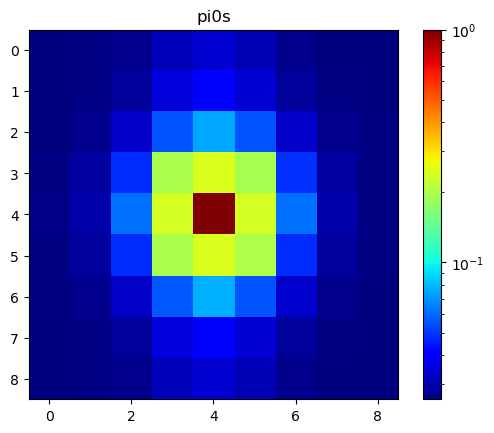

In [5]:
### visualise the dataset
dataset = np.loadtxt("output0.csv")
print(np.unique(dataset[:,81],return_counts=True))
pis = dataset[:,:81][dataset[:,81] == 0]
phos = dataset[:,:81][dataset[:,81] == 1]
from matplotlib import colors
im1 = plt.imshow(np.mean(phos.reshape(len(phos),9,9),axis=0),cmap='jet',norm=colors.LogNorm())
plt.colorbar(im1)
plt.title("photons")
plt.show()
im2 = plt.imshow(np.mean(pis.reshape(len(pis),9,9),axis=0),cmap='jet',norm=colors.LogNorm())
plt.colorbar(im2)
plt.title("pi0s")
plt.show()

In [6]:
## define dataset

from torch.utils.data import Dataset
class ClassificationDataset(Dataset):
    def __init__(self, filename, imagify=False):
        self.filename_ = filename
        self.data = np.loadtxt(self.filename_)
        self.images = torch.tensor(self.data[:,:81],dtype=torch.double)
        self.labels = torch.tensor(self.data[:,81],dtype=torch.double)
        self.imagify_ = imagify

    def __getitem__(self, idx):
        if self.imagify_:
            self.images = torch.reshape(self.images, (len(self.images),1,9, 9))
        image = self.images[idx]
        label = self.labels[idx]
        
        
        return image, label

    def __len__(self):
        return len(self.labels)

In [7]:
### create dataset, dataloaders
train_datasetCNN = ClassificationDataset("output0.csv", imagify=True)
test_datasetCNN = ClassificationDataset("output1.csv", imagify=True)
ntrainbatch = 2000
ntestbatch = 2000
from torch.utils.data import DataLoader
trainloaderCNN = DataLoader(train_datasetCNN, batch_size=ntrainbatch)
testloaderCNN = DataLoader(test_datasetCNN, batch_size=ntestbatch)

In [8]:
### define CNN model

import torch.nn as nn
import torch.nn.functional as F
class NetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 30, 3,stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(30, 15, 3,stride=1)
        self.fc1 = nn.Linear(15 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, 1)
        #self.fc4 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = nn.Dropout(p=0.2)(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = nn.Dropout(p=0.2)(x)
        #x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        #x = self.fc3(x)
        return x


netcnn = NetCNN()

In [9]:
train_datasetDNN = ClassificationDataset("output0.csv", imagify=False)
test_datasetDNN = ClassificationDataset("output1.csv", imagify=False)
ntrainbatch = 2000
ntestbatch = 2000
from torch.utils.data import DataLoader
trainloaderDNN = DataLoader(train_datasetDNN, batch_size=ntrainbatch)
testloaderDNN = DataLoader(test_datasetDNN, batch_size=ntestbatch)

In [10]:
### define DNN model
import torch.nn as nn
import torch.nn.functional as F
class NetDNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(81, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = nn.Dropout(p=0.2)(x)
        x = F.relu(self.fc2(x))
        x = nn.Dropout(p=0.2)(x)
        x = F.sigmoid(self.fc3(x))
        return x


netdnn = NetDNN()

In [11]:
#netdnn(train_datasetDNN[0][0])
train_datasetDNN[0][1].dtype

torch.float64

In [12]:
### define training and testing functions

device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
model = NetCNN().to(float) ### change to NetDNN().to(float) for DNN
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
lossfunction = nn.BCELoss()


def train(epoch):
    model.train()
    loss = []
    acc = []
    for data in tqdm(trainloaderCNN):  ### change to loaderDNN for DNN
            image, label = data[0].to(device),data[1].to(device)
            label = torch.reshape(label,(len(label),1))
            optimizer.zero_grad()
            result = model(image)
            #print(label.dtype)
            #print(result.dtype)
            lossc = lossfunction(result, label)
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            result[result < 0.5] = 0
            result[result > 0.5] = 1
            #print(result)
            match = result==label
            acc.append(len(match[match==1])/len(label))
            #scheduler.batch_step()
    print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    print('train acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.mean(np.array(acc))

def test(epoch):
    model.eval()
    loss = []
    acc = []
    for data in tqdm(testloaderCNN): ### change to loaderDNN for DNN
            image, label = data[0].to(device),data[1].to(device)
            label = torch.reshape(label,(len(label),1))
            optimizer.zero_grad()
            result = model(image)
            lossc = lossfunction(result,label )
            loss.append(lossc.item())
            result[result < 0.5] = 0
            result[result > 0.5] = 1
            #print(result)
            match = result==label
            acc.append(len(match[match==1])/len(label))
            #scheduler.batch_step()
    print( 'batches for train:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print('test acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.mean(np.array(acc))


In [13]:
### loop over the datset and train/test

from tqdm import tqdm as tqdm
nepoch=2
best_loss = 99999999
losst = []
lossv = []
acct = []
accv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    trainl = train(epoch)
    losst.append(trainl[0])
    acct.append(trainl[1])
    testl = test(epoch)
    loss_epoch = testl[0]
    lossv.append(loss_epoch)
    accv.append(testl[1])
    epochs.append(epoch)

    if loss_epoch < best_loss:
        best_loss = loss_epoch
        print('new best test loss:',best_loss)
        
    if ((epoch+1)%10 == 0):
        plt.plot(np.array(epochs),np.array(losst),c='b',label='training')
        plt.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        plt.legend()
        plt.title("loss")
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()
        plt.plot(np.array(epochs),np.array(acct),c='b',label='training')
        plt.plot(np.array(epochs),np.array(accv),c='r',label='testing')
        plt.legend()
        plt.title("accuracy")
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()
    #break

epoch: 0


100%|██████████| 35/35 [00:02<00:00, 16.21it/s]


batches for train: 35
train loss: 0.6910395806576618
train acc: 0.5406142857142857


100%|██████████| 15/15 [00:00<00:00, 35.16it/s]


batches for train: 15
test loss: 0.682968015475243
test acc: 0.5798666666666666
new best test loss: 0.682968015475243
epoch: 1


100%|██████████| 35/35 [00:01<00:00, 29.02it/s]


batches for train: 35
train loss: 0.6441268866700998
train acc: 0.649942857142857


100%|██████████| 15/15 [00:00<00:00, 45.84it/s]

batches for train: 15
test loss: 0.5911823223593896
test acc: 0.6901333333333334
new best test loss: 0.5911823223593896
